# Notes:


This notebook analyses the results of the dDM/dz values created in Pipe_Creation_Test.ipynb.

It continues using the method described in Zhang+20: https://arxiv.org/abs/2011.14494

# Imports:

In [20]:
import os

import numpy as np
import illustris_python as il

from frb.dm import igm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_dd

from astropy import units as u
from numpy import random as rand
from astropy import constants as c
from matplotlib import pyplot as plt
from astropy.cosmology import Planck15 as cosmosource


# Load Theory

In [302]:
#get theory for next plot
theory_z_2 = np.array([0.0001,0.1,0.2,0.3,0.4,0.5,0.7,1.0,1.5,2.0])
print('calculating average DMcosm')
cosm_theory_2=[igm.average_DM(i) for i in theory_z_2]
cosm_theory_2=[i.value for i in cosm_theory_2]
print('calculating average DMigm')
igm_theory_2=[igm.average_DMIGM(i) for i in theory_z_2]
igm_theory_2=[i.value for i in igm_theory_2]
print('calculating average DMhalo')
halo_theory_2=[igm.average_DMhalos(i) for i in theory_z_2]
halo_theory_2=[i.value for i in halo_theory_2]

calculating average DMcosm
calculating average DMigm
calculating average DMhalo


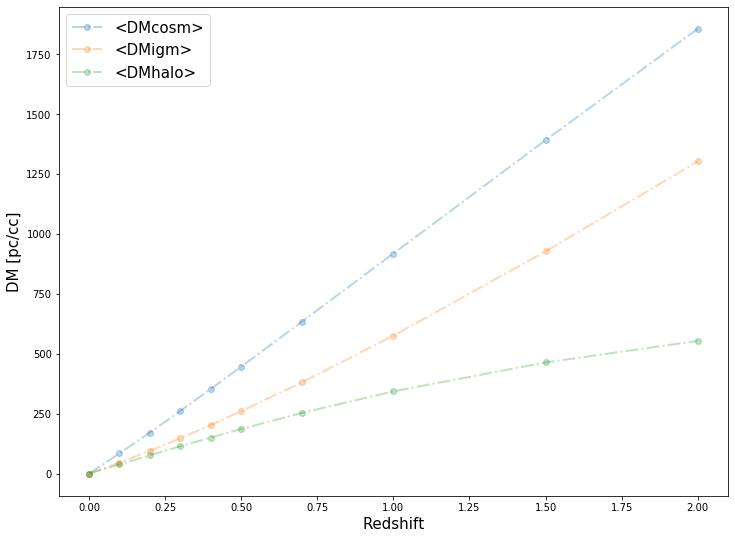

In [303]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

plt.legend(fontsize=15)
plt.show()


# Load pipe dDM/dz values

In [304]:
#############################
#Identify files to be loaded#
#############################

#all files
all_files = os.listdir('.')
#.npy files
npy_files = [i for i in all_files if '.npy' in i]
#ddmdz files
dDMdz_files = [i for i in npy_files if 'dDMdz' in i]
#sort
dDMdz_files.sort()
#reverse order
dDMdz_files = dDMdz_files[::-1]
print(dDMdz_files)

#list of snapshots wth data
snap_list = [int(i.split('_')[-1].split('.')[0]) for i in dDMdz_files]
print(snap_list)


['dDMdz_arr_for_sn_99.npy', 'dDMdz_arr_for_sn_91.npy', 'dDMdz_arr_for_sn_84.npy', 'dDMdz_arr_for_sn_78.npy', 'dDMdz_arr_for_sn_72.npy', 'dDMdz_arr_for_sn_67.npy', 'dDMdz_arr_for_sn_59.npy', 'dDMdz_arr_for_sn_50.npy', 'dDMdz_arr_for_sn_40.npy']
[99, 91, 84, 78, 72, 67, 59, 50, 40]


In [305]:
#######################################
#load the files into a data dictionary#
#######################################

#path to data
basePath = '/ptmp/cwalker/Illustris_FRB_Project/TNG_copies/virgo/simulations/IllustrisTNG/TNG100-3/output/'

dDMdz_dict = {} #initialise dictionary
snap_redshifts = {} #initialise dictionary to hold redshifts of snapshots
snap_z_list = [] #initialise an array to hold these redshift values for plotting

for i in range(len(dDMdz_files)):#loop over files
    snapshot = dDMdz_files[i].split('_')[-1].split('.')[0] #extract snapshot number
    vals = np.load(dDMdz_files[i]) #extract dDMdz values from file
    dDMdz_dict[snapshot]=vals*u.pc*u.cm**-3 #append values to dictionary with snapshot number as key
    header = il.groupcat.loadHeader(basePath,int(snapshot))
    snap_redshifts[snapshot]=header['Redshift']
    snap_z_list.append(header['Redshift'])


print(snap_redshifts['99'])    
print(dDMdz_dict['99'])
print(len(snap_redshifts))

2.220446049250313e-16
[ 843.07316146  455.99233314 3892.44327921 ...  311.1919659  1137.88483894
  318.80377803] pc / cm3
9


# Calculate DM for a single line of sight

In [306]:
#calculate DMIGM(z) for a single line of sight according to paper
x = snap_list

#set initial condition to DM(z=0)=0

DMIGM = [[0]*u.pc*u.cm**-3]

for i in range(len(x)-1): #loop over snapshots
    
    print(i)
    #get snapshot number for this snapshot
    snap_id = str(snap_list[i])
    #get snapshot number for next snapshot
    snap_id_ = str(snap_list[i+1])
    print(snap_id,snap_id_)
    #get this snapshot redshift
    snap_z = snap_redshifts[snap_id]
    #get next snapshot redshift
    snap_z_ = snap_redshifts[snap_id_]
    print(snap_z,snap_z_)
    #randomly select dDM/dz value for this redshift
    rand_dDMdz = np.random.choice(dDMdz_dict[snap_id])*u.pc*u.cm**-3
    #randomly select dDM/dz value for next redshift
    rand_dDMdz_ = np.random.choice(dDMdz_dict[snap_id_])*u.pc*u.cm**-3
    print(rand_dDMdz,rand_dDMdz_)
    
    nextDM = DMIGM[i] + ((0.5*(rand_dDMdz+rand_dDMdz_)) * (snap_z_ -  snap_z))

    DMIGM.append(nextDM)

print(len(x),len(DMIGM))

0
99 91
2.220446049250313e-16 0.09940180263022191
1627.0909298850415 pc / cm3 514.2696958492282 pc / cm3
1
91 84
0.09940180263022191 0.19728418237600986
616.8804320096946 pc / cm3 813.1151251566223 pc / cm3
2
84 78
0.19728418237600986 0.2977176845174465
932.470494047223 pc / cm3 600.6976559970826 pc / cm3
3
78 72
0.2977176845174465 0.3999269646135635
561.2669090389043 pc / cm3 1262.8943191079866 pc / cm3
4
72 67
0.3999269646135635 0.5030475232448832
836.4091504239263 pc / cm3 1159.3717627133167 pc / cm3
5
67 59
0.5030475232448832 0.7001063537185233
1131.533808642551 pc / cm3 2076.2204406648484 pc / cm3
6
59 50
0.7001063537185233 0.9972942257819404
1037.6486871119605 pc / cm3 626.364034407067 pc / cm3
7
50 40
0.9972942257819404 1.4955121664955557
693.5377022130442 pc / cm3 1253.2532255100098 pc / cm3
9 9


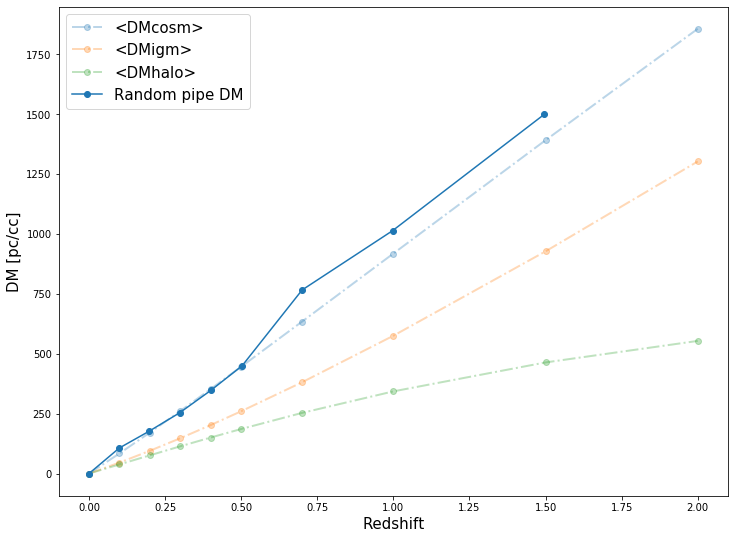

In [307]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax.plot(snap_z_list,DMIGM,marker='o',label='Random pipe DM')

plt.legend(fontsize=15)
plt.show()


# Calculate DM for many lines of sight

## figuring out array version

In [308]:
print(snap_list)

nlos = 4 #number of lines of sight

test_dDMdz_arr = np.array([np.random.choice(dDMdz_dict[str(snap_id)],size=nlos) for snap_id in snap_list])*u.pc*u.cm**-3
test_z_arr = np.array([snap_redshifts[str(snap_id)] for snap_id in snap_list])

print(test_dDMdz_arr,test_z_arr)

#single line of sight of multiple
print('\ntesting for a single los from list of sightlines\n')

print('all data: ',test_dDMdz_arr[:])
print('one los dDM vals: ',test_dDMdz_arr[:,0])
print('all but last of these: ',test_dDMdz_arr[:,0][0:-1])
print('all but first of these: ',test_dDMdz_arr[:,0][1:])
print('average of these: ', 0.5*(test_dDMdz_arr[:,0][0:-1]+test_dDMdz_arr[:,0][1:]))
print('corresponding all redshifts: ',test_z_arr[:])
print('corresponding all but first of these: ',test_z_arr[:][1:])
print('corresponding all but last of these: ',test_z_arr[:][0:-1])
print('corresponding difference between these: ',(test_z_arr[:][1:]-test_z_arr[:][0:-1]))
print('performing calculation: ', (0.5*(test_dDMdz_arr[:,0][0:-1]+test_dDMdz_arr[:,0][1:]))*(test_z_arr[:][1:]-test_z_arr[:][0:-1]))

#all lines of sight
print('\ntesting for all los from list of sightlines\n')

print('all data: ',test_dDMdz_arr[:])
print('all los dDM vals: ',test_dDMdz_arr[:,:])
print('all but last of these: ',test_dDMdz_arr[:,:][0:-1])
print('all but first of these: ',test_dDMdz_arr[:,:][1:])
print('average of these: ', 0.5*(test_dDMdz_arr[:,:][0:-1]+test_dDMdz_arr[:,:][1:]))
print('corresponding all redshifts: ',test_z_arr[:])
print('corresponding all but first of these: ',test_z_arr[:][1:])
print('corresponding all but last of these: ',test_z_arr[:][0:-1])
print('corresponding difference between these: ',(test_z_arr[:][1:]-test_z_arr[:][0:-1]))
print('giving this an extra axis: ',(test_z_arr[:][1:]-test_z_arr[:][0:-1])[:,None])
print('performing calculation: ', (0.5*(test_dDMdz_arr[:,:][0:-1]+test_dDMdz_arr[:,:][1:]))*(test_z_arr[:][1:]-test_z_arr[:][0:-1])[:,None])
test_DM_arr = (0.5*(test_dDMdz_arr[:,:][0:-1]+test_dDMdz_arr[:,:][1:]))*(test_z_arr[:][1:]-test_z_arr[:][0:-1])[:,None]
test_DM_arr = np.insert(test_DM_arr,0,np.zeros(nlos),axis=0)
print('adding z=0 values to beginning: ',test_DM_arr)
test_cDM_arr = np.cumsum(test_DM_arr,axis=0)
print('getting cDM array: ',test_cDM_arr)

[99, 91, 84, 78, 72, 67, 59, 50, 40]
[[ 539.10565722  737.73717661  420.54469963  365.18935473]
 [ 528.91543163  758.60105433  876.48740743 9184.86248642]
 [ 637.54224543  478.72300538 4122.74737633  532.15985721]
 [ 681.1222595   804.29887395  501.93751615  940.31242211]
 [1100.19011302 4796.22261666  600.2313313   578.73775194]
 [ 451.7231361   996.09923658  463.01033911  570.13271551]
 [ 549.07754298  703.6448564   588.73862544 1477.85242172]
 [2365.05550881  575.12336013  690.56889865  650.3871274 ]
 [ 705.47939845 1253.25322551 1015.59474773 1106.33946719]] pc / cm3 [2.22044605e-16 9.94018026e-02 1.97284182e-01 2.97717685e-01
 3.99926965e-01 5.03047523e-01 7.00106354e-01 9.97294226e-01
 1.49551217e+00]

testing for a single los from list of sightlines

all data:  [[ 539.10565722  737.73717661  420.54469963  365.18935473]
 [ 528.91543163  758.60105433  876.48740743 9184.86248642]
 [ 637.54224543  478.72300538 4122.74737633  532.15985721]
 [ 681.1222595   804.29887395  501.93751615 

## creating array of cDM for many sightlines

In [309]:
nlos = 10000000 #number of lines of sight

#create an array of randomly drawn dDMdz values
dDMdz_arr = np.array([np.random.choice(dDMdz_dict[str(snap_id)],size=nlos) for snap_id in snap_list])*u.pc*u.cm**-3
#create array of redshifts
z_arr = np.array([snap_redshifts[str(snap_id)] for snap_id in snap_list])

#perform the calculation to get DM at each redshift
DM_arr = (0.5*(dDMdz_arr[:,:][0:-1]+dDMdz_arr[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None]
#add the initial condition of DM=0@z=0
DM_arr = np.insert(DM_arr,0,np.zeros(nlos),axis=0)
#perform the cumulative sum to get the cDM for each light ray
cDM_arr = np.cumsum(DM_arr,axis=0)

#print(DM_arr)
#print(cDM_arr)
print(cDM_arr.shape)

(9, 10000000)


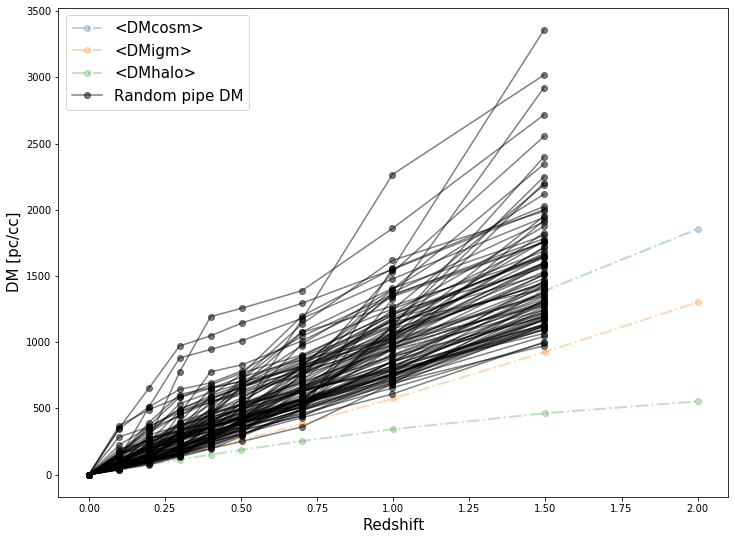

In [310]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

for i in range(100):
    if i==0:
        ax.plot(snap_z_list,cDM_arr[:,i],marker='o',color='k',alpha=0.5,label='Random pipe DM')
    else:
        ax.plot(snap_z_list,cDM_arr[:,i],marker='o',color='k',alpha=0.5)

plt.legend(fontsize=15)
plt.show()

## get statistics

In [311]:
mean_cDM_arr = np.mean(cDM_arr,axis=1) #mean
medi_cDM_arr = np.median(cDM_arr,axis=1) #median
stdv_cDM_arr = np.std(cDM_arr,axis=1) #standard deviation

print('Mean cDM: ',mean_cDM_arr)
print('Median cDM: ',medi_cDM_arr)
print('Standard deviation of cDM: ',stdv_cDM_arr)

Mean cDM:  [   0.           99.58371412  202.29769019  310.21226283  421.03760791
  533.24904861  752.18173266 1084.28323497 1613.24024345] pc / cm3
Median cDM:  [   0.           73.47017233  157.75294532  253.59870493  356.76551467
  463.91330626  669.77401891  979.24060828 1479.45225459] pc / cm3
Standard deviation of cDM:  [  0.         104.21102272 167.89624031 217.05307643 249.72422221
 273.98567659 334.78939851 445.4926318  575.99424847] pc / cm3


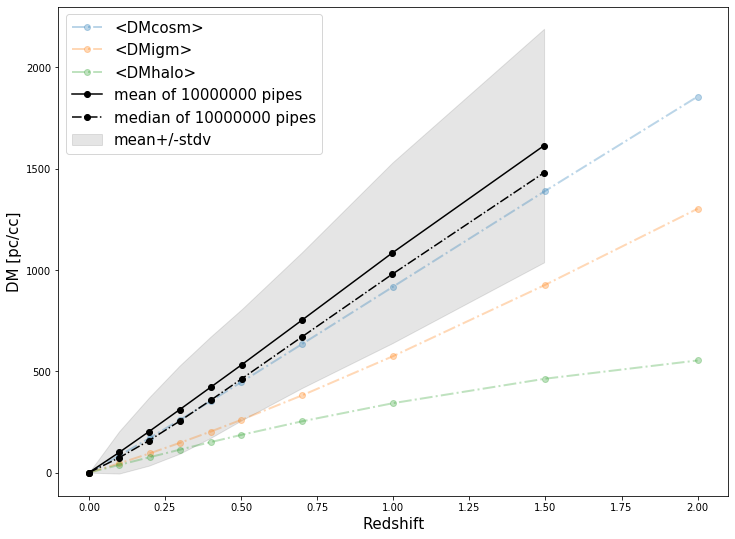

In [312]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax.plot(snap_z_list,mean_cDM_arr,marker='o',color='k',alpha=1,ls='-',label='mean of {0} pipes'.format(cDM_arr.shape[1]))
ax.plot(snap_z_list,medi_cDM_arr,marker='o',color='k',alpha=1,ls='-.',label='median of {0} pipes'.format(cDM_arr.shape[1]))
ax.fill_between(snap_z_list,mean_cDM_arr+stdv_cDM_arr,mean_cDM_arr-stdv_cDM_arr,alpha=0.1,color='k',label='mean+/-stdv')
plt.legend(fontsize=15)
plt.show()

# Histograms of results 

In [313]:
#method for histogramming over one axis from https://stackoverflow.com/questions/40018125/binning-of-data-along-one-axis-in-numpy

def hist_1d(data,bins=np.linspace(0,5000,100)):
    """
    histograms data along one axis
    adapted from https://stackoverflow.com/questions/40018125/binning-of-data-along-one-axis-in-numpy
    
    INPUTS:
    
    data : [arr]  array of data to histogram
    """
    
    return np.histogram(data,bins=bins,normed=True)[0]

bin_edges = np.linspace(0,5000,500)
counts = np.apply_along_axis(hist_1d, 1, cDM_arr.value,bin_edges)

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  del sys.path[0]


In [314]:
print(counts.shape)
print(bin_edges.shape)

(9, 499)
(500,)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986


No handles with labels found to put in legend.
No handles with labels found to put in legend.


3 0.2977176845174465
4 0.3999269646135635


No handles with labels found to put in legend.
No handles with labels found to put in legend.


5 0.5030475232448832
6 0.7001063537185233


No handles with labels found to put in legend.


7 0.9972942257819404
8 1.4955121664955557


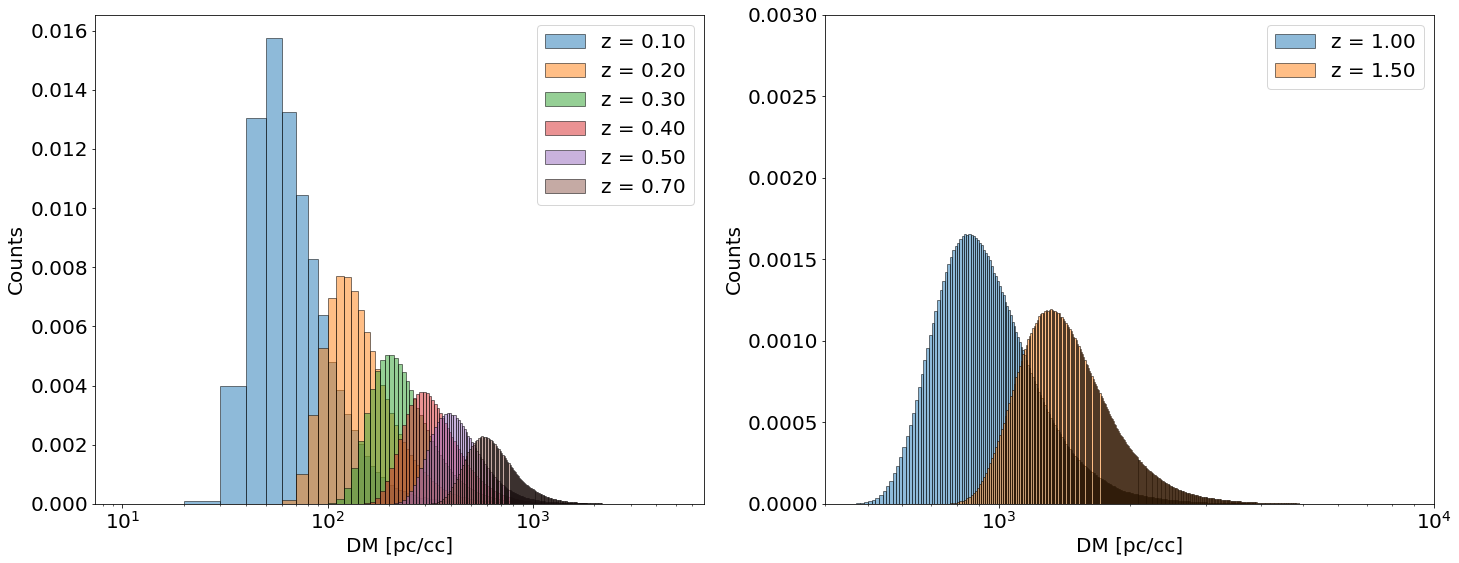

In [315]:
#histogram method from: https://stackoverflow.com/questions/64616617/matplotlib-plot-histogram-given-pre-computed-counts-and-bins

fig = plt.figure(figsize=(24,9))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('DM [pc/cc]',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2 = fig.add_subplot(122)
ax2.set_xlabel('DM [pc/cc]',fontsize=20)
ax2.set_ylabel('Counts',fontsize=20)
ax2.set_xscale('log')
ax2.set_ylim([0,0.003])
ax2.set_xlim([4e2,1e4])
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i<7:
        print(i,snap_z_list[i])
        ax1.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
    elif i>=7:
        print(i,snap_z_list[i])
        ax2.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
        #plt.legend(fontsize=15)
    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20)



# Plot the fits from Zhang+20

10
[0.1 0.2 0.3 0.4 0.5 0.7 1.  1.5]


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply


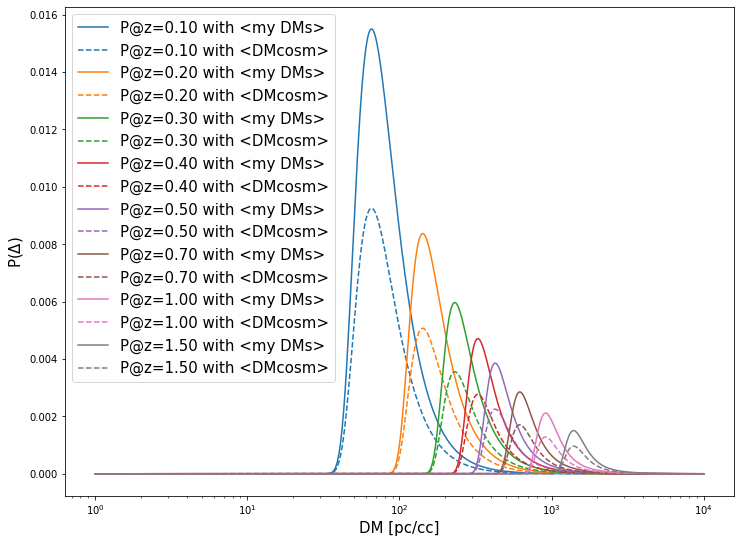

In [333]:
#print(snap_z_list[1:])
#print(np.linspace(0.01,10000))
#print(mean_cDM_arr)
print(len(cosm_theory_2))
print(np.array(theory_z_2)[1:-1])

xarr = np.linspace(0,10000,10000)

#I was unsure what <DMIGM> should go into the data so I did two tests below:
#Test 1: <DMIGM> is the mean of my DM IGM values
Delta_mydata = np.array([xarr/i for i in mean_cDM_arr[1:]]) #DMIGM/<DMIGM> (only for z=0.1 and above) using the mean of my data
#Test 2: <DMIGM> is the value from the macquart relation (i.e. <DMcosm)
Delta_macq = np.array([xarr/i for i in np.array(cosm_theory_2)[1:-1]]) #DMIGM/<DMIGM> (only for z=0.1 and above) using the macquart relation

A = np.array([0.04721,0.005693,0.003584,0.002876,0.002423,0.001880,0.001456,0.001098]) #from Zhang+20 table 1
alpha=3
beta=3
C0 = np.array([-13.17,-1.008,0.596,1.010,1.127,1.170,1.189,1.163]) #from Zhang+20 table 1
sigmaDM = np.array([2.554,1.118,0.7043,0.5158,0.4306,0.3595,0.3044,0.2609]) #from Zhang+20 table 1


#create the P curves for each Delta
P_mydata=(A[:,None]*(Delta_mydata)**(-1*beta))*np.exp(-1*((((Delta**(-1*alpha))-C0[:,None])**2)/(2*alpha**2*sigmaDM[:,None]**2)))
P_macq=(A[:,None]*(Delta_macq)**(-1*beta))*np.exp(-1*((((Delta**(-1*alpha))-C0[:,None])**2)/(2*alpha**2*sigmaDM[:,None]**2)))

#plot to test
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('DM [pc/cc]',fontsize=15)
ax.set_ylabel('P($\Delta$)',fontsize=15)
ax.set_xscale('log')
for i in range(P.shape[0]):
    ax.plot(xarr,P_mydata[i],color='C{0}'.format(i),label='P@z={0:.2f} with <my DMs>'.format(snap_z_list[1:][i]))
    ax.plot(xarr,P_macq[i],ls='--',color='C{0}'.format(i),label='P@z={0:.2f} with <DMcosm>'.format(snap_z_list[1:][i]))


plt.legend(fontsize=15)
#print(Delta)

Result: it looks as though we are meant to take the mean of our own values to recreate these fits. This should be discussed with Laura as our values are actually different to Zhangs, and so these curves might also differ...

# Overplot the fits on the histograms

No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191


No handles with labels found to put in legend.


2 0.19728418237600986


No handles with labels found to put in legend.


3 0.2977176845174465


No handles with labels found to put in legend.


4 0.3999269646135635


No handles with labels found to put in legend.


5 0.5030475232448832


No handles with labels found to put in legend.


6 0.7001063537185233


No handles with labels found to put in legend.


7 0.9972942257819404
8 1.4955121664955557


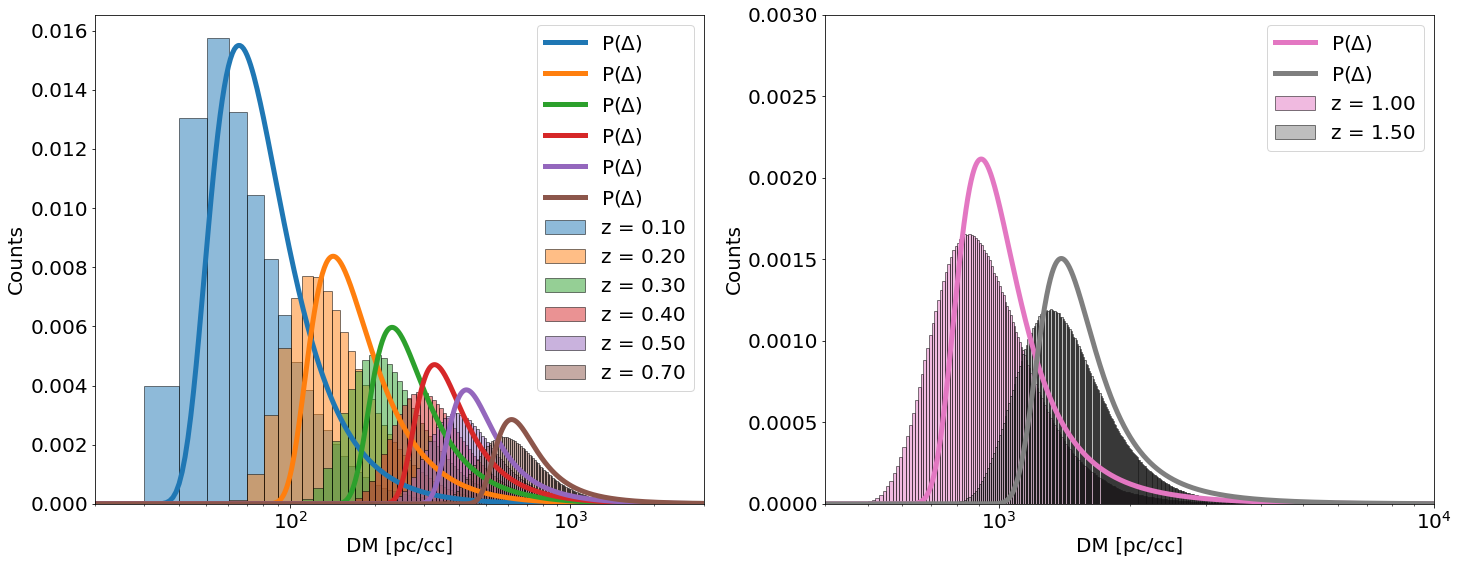

In [343]:
fig = plt.figure(figsize=(24,9))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('DM [pc/cc]',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_xscale('log')
ax1.set_xlim([2e1,3e3])
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2 = fig.add_subplot(122)
ax2.set_xlabel('DM [pc/cc]',fontsize=20)
ax2.set_ylabel('Counts',fontsize=20)
ax2.set_xscale('log')
ax2.set_ylim([0,0.003])
ax2.set_xlim([4e2,1e4])
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i<7:
        print(i,snap_z_list[i])
        ax1.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax1.plot(xarr,P_mydata[i-1],color='C{0}'.format(i-1),lw=5,label='P($\Delta$)'.format(snap_z_list[1:][i-1]))
        
    elif i>=7:
        print(i,snap_z_list[i])
        ax2.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax2.plot(xarr,P_mydata[i-1],color='C{0}'.format(i-1),lw=5,label='P($\Delta$)'.format(snap_z_list[1:][i-1]))

        #plt.legend(fontsize=15)
    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20)